In [1]:
import os
import torch
import json
from io import BytesIO
import numpy as np
import torch.nn as nn
import imageio.v2 as imageio
from tqdm import tqdm, trange
from utils import SphericalNODataset, get_cr_dirs
from neuralop.models import SFNO
import matplotlib.pyplot as plt
from psipy.model import MASOutput

/Users/reza/Career/DMLab/SURROGATE/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
device = torch.device('cpu')

In [3]:
data_path = '/Users/reza/Career/DMLab/SURROGATE/Data/psi_web_sample/test'
result_path = '/Users/reza/Career/DMLab/SURROGATE/results/sfno/exp_35'
cfg_path = os.path.join(result_path, 'cfg.json')
with open(cfg_path, 'r') as f:
    cfg = json.load(f)

In [4]:
len(cfg['train_files'])

492

In [5]:
cr_paths = get_cr_dirs(data_path)

In [6]:
cr_paths

['cr2234', 'cr2238', 'cr2241']

In [7]:
dataset = SphericalNODataset(
    data_path,
    cr_paths,
    v_min=cfg["v_min"],
    v_max=cfg["v_max"],
)

Loading simulations: 100%|██████████| 6/6 [00:00<00:00, 95.96it/s]


In [8]:
cfg

{'num_epochs': 200,
 'batch_size': 32,
 'learning_rate': 0.0008,
 'train_files': ['cr1625',
  'cr1626',
  'cr1627',
  'cr1628',
  'cr1629',
  'cr1630',
  'cr1633',
  'cr1634',
  'cr1636',
  'cr1638',
  'cr1649',
  'cr1651',
  'cr1652',
  'cr1653',
  'cr1654',
  'cr1655',
  'cr1656',
  'cr1657',
  'cr1659',
  'cr1660',
  'cr1662',
  'cr1664',
  'cr1666',
  'cr1667',
  'cr1668',
  'cr1670',
  'cr1671',
  'cr1672',
  'cr1673',
  'cr1674',
  'cr1675',
  'cr1676',
  'cr1677',
  'cr1680',
  'cr1681',
  'cr1682',
  'cr1683',
  'cr1684',
  'cr1685',
  'cr1686',
  'cr1687',
  'cr1688',
  'cr1689',
  'cr1690',
  'cr1691',
  'cr1692',
  'cr1694',
  'cr1695',
  'cr1696',
  'cr1698',
  'cr1700',
  'cr1701',
  'cr1702',
  'cr1703',
  'cr1704',
  'cr1706',
  'cr1707',
  'cr1709',
  'cr1711',
  'cr1713',
  'cr1714',
  'cr1715',
  'cr1716',
  'cr1717',
  'cr1718',
  'cr1719',
  'cr1720',
  'cr1721',
  'cr1722',
  'cr1724',
  'cr1726',
  'cr1728',
  'cr1729',
  'cr1730',
  'cr1731',
  'cr1732',
  'cr173

In [9]:
cfg['v_min'], cfg['v_max']

(0.4673037827014923, 1.591561198234558)

In [10]:
model = SFNO(
    n_modes=(110, 128),
    in_channels=1,
    out_channels=139,
    hidden_channels=cfg['hidden_channels'],
    projection_channel_ratio=2,
    factorization='dense',
    n_layers=cfg['n_layers']
)
state = torch.load(os.path.join(result_path, "model.pt"), map_location=device, weights_only=False)
model.load_state_dict(state)

<All keys matched successfully>

In [31]:
I = 4
instance = dataset[I]
x, y = instance['x'], instance['y']

# cube = torch.randn((1, 141, 64, 64), dtype=torch.float32)
# cube[:, :, 20:40, :] = 1

# x = cube[:, 0, :, :]
# y = cube[0, 1:, :, :]

model.eval()
with torch.no_grad():
    yhats = model(x.unsqueeze(0))
    
# del model

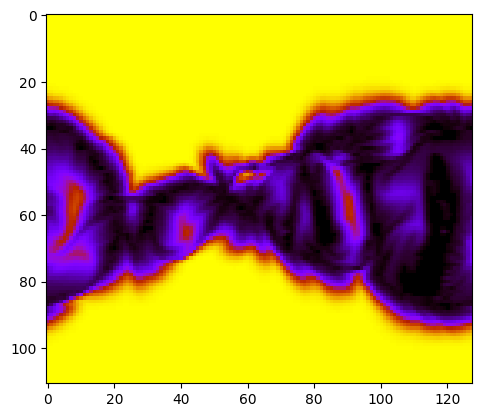

In [32]:
plt.imshow(y[0], cmap='gnuplot')

In [33]:
cube = y

yhats = yhats * (cfg["v_max"] - cfg["v_min"]) + cfg["v_min"]
cube = cube * (cfg["v_max"] - cfg["v_min"]) + cfg["v_min"]

yhats *= 481.3711
cube *= 481.3711

In [34]:
vmin = cube.min()
vmax = cube.max()
max_error = np.abs(cube - yhats[0]).max()

frames = []
for i in trange(139):
    y = cube[i, :, :]
    yhat = yhats[0, i, :, :]

    error = np.abs(y - yhat)
    
    fig, axes = plt.subplots(1, 3, figsize=(12, 6))
    cmap = "gnuplot"

    # # Plot first subplot
    im1 = axes[0].imshow(y, cmap=cmap, vmin=vmin, vmax=vmax)
    axes[0].set_title(f"gt: vr002 at {i+1}")

    # Plot second subplot
    im3 = axes[1].imshow(yhat, cmap=cmap, vmin=vmin, vmax=vmax)
    axes[1].set_title(f"pred at {i+1} ")

    cbar = fig.colorbar(im1, ax=axes, orientation="horizontal", fraction=0.1, pad=0.02)
    cbar.set_label('$\dfrac{km}{s}$', fontsize='10', rotation=360, labelpad=5)

    # Plot second subplot
    im4 = axes[2].imshow(error, cmap="gray", vmin=0, vmax=max_error)
    axes[2].set_title(f"|pred-gt|")

    # Create a single colorbar
    cbar = fig.colorbar(im4, ax=axes, orientation="vertical", fraction=0.05, pad=0.02)

    # plt.tight_layout()
    buf = BytesIO()
    plt.savefig(buf, format="png")
    frames.append(imageio.imread(buf))
    plt.close()

  0%|          | 0/139 [00:00<?, ?it/s]

100%|██████████| 139/139 [00:25<00:00,  5.40it/s]


In [35]:
output_filename = f"v{I}.gif"
fps = 10  # Adjust frames per second as needed

# Create video directly from frames in memory
with imageio.get_writer(output_filename, fps=fps, loop=0) as writer:
    for frame in frames:
        writer.append_data(frame)